# Finetune no dataset do SROIE

Este Dataset contém o código de finetune do modelo no dataset de recibos da tarefa SROIE do ICDAR. O modelo parte de pesos pré-treinados. A rotina de pré treino está disponível em https://colab.research.google.com/drive/1craSjUlWaC-MDn34MPXOKq_SDips7N2Q?usp=sharing.

Após algumas tentativas com a U-NET, segmentando caracters da imagem de entrada como forma de codificação da imagem, optei por uma nova abordagem inspirado no UNITER: 

> Chen, Y.-C., Li, L., Yu, L., Kholy, A. El, Ahmed, F., Gan, Z., Cheng, Y., & Liu, J. (n.d.). UNITER: UNiversal Image-TExt Representation Learning. Retrieved December 2, 2020, from https://github.com/ChenRocks/UNITER.

A abordagem é basicamente a seguinte:

1. A rede é um `Transformer` pré-treinado (`t5-base`)
2. A entrada é composta de dois elementos: **(1)** patches de 16x16 da imagem do recibo e **(2)** Um texto `company: <extra_id_0>` para o qual `Transformer` deve prever o valor de `<extra_id_0>`.
3. Os patches da imagem são submetidos a um `ImageEmbedder`, que contém codificação posicional.
4. O texto é submetido a um `TextEmbedder`, que é basicamente a camada de Embeddings do T5.

A imagem a seguinte representa a arquitetura do modelo:


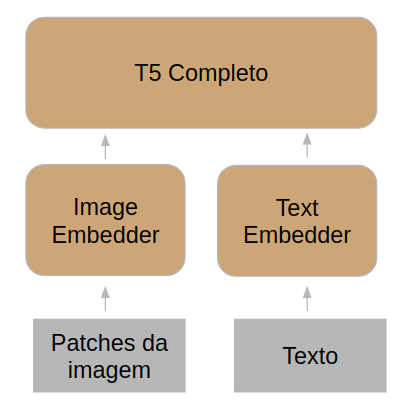

O pré treino é conduzido em imagens sintéticas, extraída da WikiText. A tarefa de pré-treino consiste de apresentar ao modelo os patches da imagem sintética + o texto da imagem, com alguns *tokens* mascarados. O modelo deve, então, prever quais os tokens foram mascarados. Esta é a primeira tarefa do paper do UNITER e o objetivo é alinhar as representações de texto e imagem.

## Setup

In [1]:
!nvidia-smi

Wed Jan 13 00:37:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install --upgrade pyarrow --quiet
!pip install --upgrade future --quiet
!pip install --upgrade transformers --quiet
!pip install --upgrade neptune-client --quiet

!pip install git+https://github.com/PytorchLightning/pytorch-lightning.git@master --upgrade --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


## Imports

In [3]:
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import transforms
from transformers import T5TokenizerFast, T5Model, T5ForConditionalGeneration

import pytorch_lightning as pl

from argparse import Namespace
from getpass import getpass
from itertools import product
from pathlib import Path
from PIL import Image, ImageFont, ImageDraw
from random import choice, randint, random, sample

from google.colab import drive

from typing import Tuple, List, Callable, Union

logging.basicConfig(level=logging.INFO)

%matplotlib inline

## Parâmetros e volumes

In [4]:
TEST_MODEL = False
OVERFIT_ONE_BATCH = False

if os.path.exists('./neptune_key'):
    with open('./neptune_key', 'r') as nep_key:
        all_lines = nep_key.readlines()

        NEPTUNE_API_KEY = all_lines[0].strip()
        NEPTUNE_PROJECT = all_lines[1].strip()
else:
    NEPTUNE_API_KEY = getpass('NEPTUNE KEY:')
    NEPTUNE_PROJECT = input('NEPTUNE PROJECT:')

    with open('./neptune_key', 'w+') as nep_key:
        nep_key.writelines([NEPTUNE_API_KEY + '\n', NEPTUNE_PROJECT + '\n'])


drive.mount('./drive')

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


## Dataset

In [5]:
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula8/dataset_sroie_icdar_2019.zip .
!unzip -n -q dataset_sroie_icdar_2019.zip

Skipping existing item: file://./dataset_sroie_icdar_2019.zip


### Extraindo Patches das Imagens

Vou Usar patches (subplots da imagem) para alimentar um Image Embedder, parecido com a abordagem do UNITER.

In [6]:
PATCH_TRANSFORMS = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

def extract_patches(image,
                    patch_height: int = 16,
                    patch_width:int = 16,
                    max_patches: int = 256,
                    padding: bool = True,
                    padding_value: int = -100):
    """
    Inspired by: https://discuss.pytorch.org/t/slicing-image-into-square-patches/8772/3
    """
    flat_image = PATCH_TRANSFORMS(image)
    patches = flat_image.data.unfold(1, patch_height, patch_height) \
                             .unfold(2, patch_width, patch_width)

    # At the end, remove the channel (since it is always one)
    patches = torch.flatten(patches, start_dim=1, end_dim=2).squeeze(0)

    # Check if padding is necessary
    if patches.shape[0] < max_patches and padding is True:
        padding = torch.zeros(max_patches - patches.shape[0],
                              patch_height,
                              patch_width)
        
        patches = torch.cat((patches, padding), dim=0)

    # Limit number of patches
    return patches[:max_patches, : , :]


def visualize_patches(patches):
    """Imshow for Tensor.""" 


    print(patches.shape)
    patch_height = patches.shape[-2]
    patch_width = patches.shape[-1]
    num_patches = patches.shape[-3]

    transp = transforms.ToPILImage()

    fig = plt.figure(figsize=(64, 32))

    for i in range(num_patches):
        inp = transp(patches[0][i])
        inp = np.array(inp)
        ax = fig.add_subplot(1, num_patches, i + 1, xticks=[], yticks=[])
        plt.imshow(inp)

torch.Size([1, 10, 64, 64])


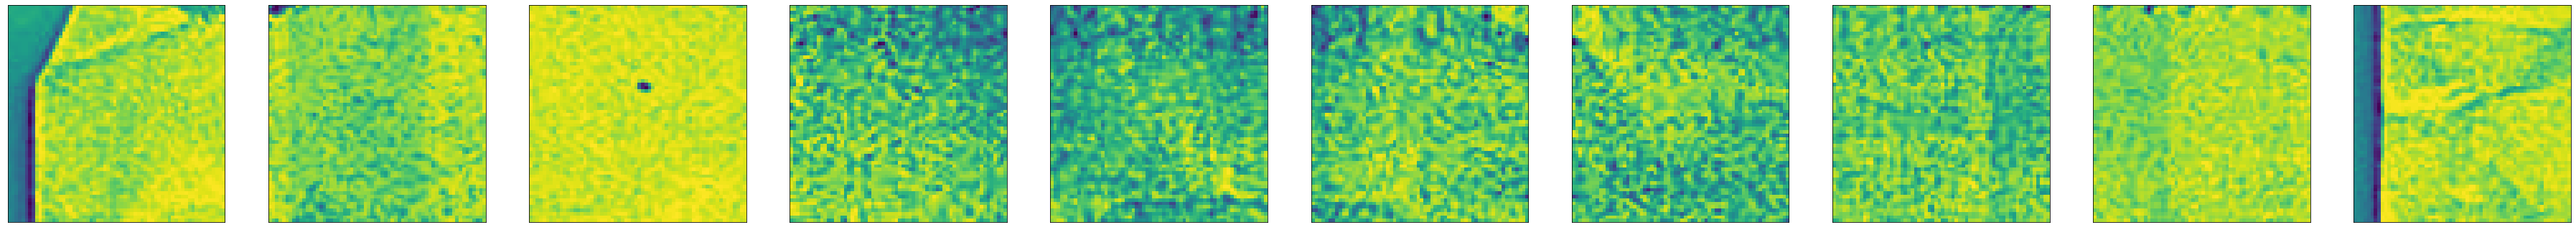

In [7]:
image = Image.open('test/X51007339650.jpg')
visualize_patches(extract_patches(image, 64, 64, padding=False, max_patches=10).unsqueeze(0))

### Removendo \<pad> e \</s>

In [8]:
def decode_sentence_batch(tokenizer, input_ids):

    def remove_pad(text):
        return text.replace(tokenizer.pad_token, '')

    def remove_eos(text):
        return text.replace(tokenizer.eos_token, '')

    dec = tokenizer.decode
    return [remove_pad(remove_eos(dec(s))).strip() for s in input_ids]


tok = T5TokenizerFast.from_pretrained('t5-base')
input_ids = tok('this is a string for testing',
                max_length=20,
                padding='max_length',
                return_tensors='pt').input_ids

print(input_ids.shape)
print(tok.batch_decode(input_ids))
print(decode_sentence_batch(tok, input_ids))

torch.Size([1, 20])
['this is a string for testing</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']
['this is a string for testing']


### Classe do Dataset

In [9]:
class SROIEDataset(Dataset):
    """
    Dataset da tarefa SROIE do ICDAR.
    Inspirado em: https://github.com/Michael-Xiu/ICDAR-SROIE/
    """

    def __init__(self,
                 data_dir: str,
                 tokenizer: Union[str, T5TokenizerFast],
                 patches_size: Tuple[int, int] = (16, 16),
                 max_patches: int = 256,
                 inquiry_max_length: int = 64,
                 target_max_length: int = 128,
                 return_image: bool = False):
        assert os.path.isdir(data_dir)

        self.image_refs = sorted([str(p) for p in Path(data_dir).glob('**/*.jpg')])
        self.object_refs = sorted([str(p) for p in Path(data_dir).glob('**/*.txt')])
        self.objects = []
        self.patches_size = patches_size
        self.max_patches = max_patches
        self.return_image = return_image

        if isinstance(tokenizer, str):
            tokenizer = T5TokenizerFast.from_pretrained(tokenizer)

        self.tokenizer = tokenizer
        self.inquiry_max_length = inquiry_max_length
        self.target_max_length = target_max_length

        for object_ref in self.object_refs:
            with open(object_ref, 'r') as o_file:
                self.objects.append(json.load(o_file))

        assert len(self.image_refs) == len(self.object_refs)
        assert len(self.image_refs) == len(self.objects)

        first, last = self.image_refs[0], self.image_refs[-1]
        ofirst, olast = self.object_refs[0], self.object_refs[-1]

        assert first[:len(first) - 3] == ofirst[:len(first) - 3]
        assert last[:len(first) - 3] == olast[:len(first) - 3]

    def __len__(self):
        return len(self.objects)

    def __getitem__(self, idx):
        obj = self.objects[idx]
        image_ref = self.image_refs[idx]

        image = Image.open(image_ref, 'r')
        image = image.convert('RGB')

        # Extract image patches
        patches = extract_patches(
            image, self.patches_size[0], self.patches_size[1], self.max_patches)

        # Prediction inquiry
        inquiry = f'company: {self.tokenizer.additional_special_tokens[0]}'
        tokenized_inq = self.tokenizer(inquiry,
                                       max_length=self.inquiry_max_length,
                                       padding='max_length',
                                       truncation=True)
        
        # Expected labels
        label = obj.get('company', '')
        tokenized_label = self.tokenizer(label,
                                         max_length=self.target_max_length,
                                         padding='max_length',
                                         truncation=True)
        output = {
            'patches': patches,
            'input_ids': torch.tensor(tokenized_inq.input_ids, dtype=torch.long),
            'target_ids': torch.tensor(tokenized_label.input_ids, dtype=torch.long),
            'original': label
        }

        if self.return_image:
            output['image'] = image

        return output

In [10]:
dataset = SROIEDataset('./train', 't5-base', patches_size=(64, 64),
                       return_image=True)

len(dataset)

426

In [11]:
demo_sample = dataset[0]
visualize_patches(demo_sample['patches'].unsqueeze(0))

torch.Size([1, 256, 64, 64])


torch.Size([1, 256, 64, 64])


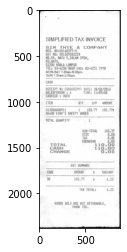

In [12]:
demo_sample = dataset[400]

plt.imshow(demo_sample['image'])
visualize_patches(demo_sample['patches'].unsqueeze(0))

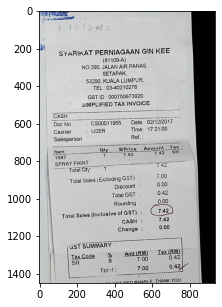

In [13]:
demo_sample = dataset[100]

plt.figure(figsize=(5, 5))
plt.imshow(demo_sample['image'])

In [14]:
demo_sample['input_ids']

tensor([  349,    10, 32099,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])

In [15]:
decode_sentence_batch(dataset.tokenizer, demo_sample['input_ids'].view(1, -1))

['company:<extra_id_0>']

## Funções de Geração de texto

In [16]:
def greedy_generate(model,
                    tokenizer,
                    embeddings,
                    device,
                    max_sentence_length: int = 128):
    """
    Realiza a geração de texto usando a técnica Greedy.
    Este método foi construído para superar algumas limitações de uso do 
    método generate dos transformers por conta do uso de um encoder
    de imagem.
    """
    eos_token_id = tokenizer.eos_token_id
    pad_token_id = tokenizer.pad_token_id
    start_token_id = model.decoder.config.decoder_start_token_id

    decoded_ids = torch.full(
        (embeddings.shape[0], 1), # Shape = (Batch Size, 1)
        start_token_id,
        dtype=torch.long, device=device)

    t5_encoder_outputs = model.get_encoder()(
        inputs_embeds=embeddings)

    for step in range(1, max_sentence_length):
        output = model(
            decoder_input_ids=decoded_ids,
            encoder_outputs=t5_encoder_outputs)

        logits = output.logits

        next_token_logits = logits[:, -1, :]
        next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

        decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

        if torch.eq(next_token_id, eos_token_id).all():
            break  # Early stop, when all sentences reached the end
    
    return decoded_ids

## Métricas

Usar as funções abaixo para calcular as métricas (exact match e F1):

In [17]:
import collections

def normalize_answer(s):
    """Lower text and remove extra whitespace."""

    def white_space_fix(text):
        return ' '.join(text.split())

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))


def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()


def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))


def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def extract_masked_tokens(text):
    matches = re.findall(r'<(extra_id_\d+)>\s*([^\<]+)\s*', text)
    return set([f'{k}={v.strip()}' for k, v in matches])


def accuracy(predicted, expected):
    predicted_set = extract_masked_tokens(predicted)
    expected_set = extract_masked_tokens(expected)    

    if not predicted_set and not expected_set:
        return 1.0  # Tanto previsão quanto expectativa são conjuntos vazios
                    # Então assumo que o modelo acertou

    total = max(len(predicted_set), len(expected_set))

    return len(predicted_set & expected_set) / total

In [18]:
compute_f1(a_gold='He likes pizza', a_pred='she likes pizza')

0.6666666666666666

In [19]:
compute_exact(a_gold='He likes pizza', a_pred='she likes pizza')

0

In [20]:
predicted = (
    '<extra_id_0> is <extra_id_1> transitional <extra_id_2> zones '
    '<extra_id_3> a <extra_id_4> in my city <extra_id_5> in my city')

expected = (
    '<extra_id_0> a <extra_id_1> transitional <extra_id_2> zones '
    '<extra_id_3> a <extra_id_4> in my city')

accuracy(predicted, expected)

0.6666666666666666

## Modelo

### Embeddings

In [21]:
class ImageEmbedding(nn.Module):
    """ Inspired by UNITER UniterImageEmbeddings. """

    def __init__(self,
                 hidden_size: int,
                 patches_size: Tuple[int, int] = (16, 16),
                 hidden_dropout_prob: float = 0.1):
        super().__init__()

        img_dim = patches_size[0] * patches_size[1]

        self.img_linear = nn.Linear(img_dim, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, patches):
        batch_size = patches.shape[0]
        seq_length = patches.shape[1]

        img_feat = patches.reshape(batch_size, seq_length, -1)

        image_embeddings = self.LayerNorm(self.img_linear(img_feat))
        image_embeddings = self.dropout(image_embeddings)
        
        return image_embeddings

In [22]:
class JointEmbedder(nn.Module):
    def __init__(self,
                 base_model: T5Model,
                 patches_size: Tuple[int, int] = (16, 16)):
        super().__init__()

        hidden_size = base_model.config.d_model

        self.image_embedder = ImageEmbedding(
            hidden_size,
            patches_size,
            getattr(base_model.config, 'dropout_rate', 0.1))
        
        self.text_embedder = base_model.get_input_embeddings()

        self.token_types_embedding = nn.Embedding(2, hidden_size)

    def forward(self, patches, masked_input_ids):
        batch_size, img_seq_length = patches.shape[:2]

        image_embeddings = self.image_embedder(patches)
        text_embeddings = self.text_embedder(masked_input_ids)

        image_token_types = torch.zeros(
            batch_size,
            img_seq_length,
            dtype=torch.long,
            device=patches.device)

        text_token_types = torch.ones(
            batch_size,
            masked_input_ids.shape[1],
            dtype=torch.long,
            device=patches.device)

        token_types = torch.cat((image_token_types, text_token_types), dim=1)
        token_type_embeddings = self.token_types_embedding(token_types)

        input_embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
        input_embeddings = input_embeddings + token_type_embeddings

        return input_embeddings

### Modelo

In [23]:
class FinetuneModel(pl.LightningModule):
    """
    Using a new Finetune model

    The submodules and parameters are the same as in the pretrained model.
    I just update the training and eval procedure.
    """
    def __init__(self,
                 model_name: str,
                 patches_size: Tuple[int, int],
                 learning_rate: float,
                 generator_function_name: str = 'greedy_generate',
                 max_sentence_length: int = 128,
                 **kwargs):

        super().__init__()

        self.save_hyperparameters()

        t5_model = T5ForConditionalGeneration.from_pretrained(model_name)
        
        self.transformer = t5_model
        self.embedder = JointEmbedder(self.transformer, patches_size)
        
        self.generate = globals()[generator_function_name]
        self.tokenizer = T5TokenizerFast.from_pretrained(model_name)
        
    def forward(self, patches, input_ids, target_ids, **kwargs):
        embeddings = self.embedder(patches, input_ids)
        
        if self.training:
            labels = target_ids.masked_fill(
                target_ids == self.tokenizer.pad_token_id,
                -100)

            output = self.transformer(inputs_embeds=embeddings,
                                      labels=labels,
                                      return_dict=True)
            
            return output.loss
        else:
            return self.generate(self.transformer,
                                 self.tokenizer,
                                 embeddings,
                                 self.device,
                                 self.hparams.max_sentence_length)
            
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), self.hparams.learning_rate)

    def training_step(self, batch, batch_idx):
        loss = self(**batch)

        self.log('train_loss', loss)

        return loss

    def validation_step(self, batch, batch_idx):
        return self._evaluation_step(batch, batch_idx)

    def validation_epoch_end(self, outputs):
        return self._evaluation_epoch_end(outputs, 'val')

    def test_step(self, batch, batch_idx):
        return self._evaluation_step(batch, batch_idx)

    def test_epoch_end(self, outputs):
        return self._evaluation_epoch_end(outputs, 'test')

    def _evaluation_step(self, batch, batch_idx):
        predicted = self(**batch)
        expected = batch['original']

        predicted_texts = decode_sentence_batch(self.tokenizer, predicted)

        return {'predicted': predicted_texts, 'actual': expected}

    def _evaluation_epoch_end(self, outputs, prefix='val'):
        predicted = [o for bouts in outputs for o in bouts['predicted']]
        actual = [o for bouts in outputs for o in bouts['actual']]

        f1_by_sample = [compute_f1(a, p) for a, p in zip(predicted, actual)]
        em_by_sample = [compute_exact(a, p) for a, p in zip(predicted, actual)]
        ac_by_sample = [accuracy(a, p) for a, p in zip(predicted, actual)]

        sample_idx = sample(range(len(predicted)), 5)
        
        if self.current_epoch % 2 == 0:
            for i in sample_idx:
                self.logger.experiment.log_text(
                    'predictions',
                    f'Actual: {actual[i]}. Predicted: {predicted[i]}.')

        f1 = 100 * (sum(f1_by_sample) / len(f1_by_sample))
        em = 100 * (sum(em_by_sample) / len(em_by_sample))
        ac = 100 * (sum(ac_by_sample) / len(ac_by_sample))

        self.log(f'{prefix}_f1', torch.tensor(f1))
        self.log(f'{prefix}_em', torch.tensor(em))
        self.log(f'{prefix}_accuracy', torch.tensor(ac))

## Treino

### Parâmetros de treino

In [24]:
train_params = {
    'seed': 42,
    'data_path': './train',
    'patches_size': (16, 16),
    'max_patches': 256,
    'target_max_length': 128,
    'max_sentence_length': 128,
    'model_name': 't5-base',
    'pretrained_model': './drive/My Drive/IA376J/checkpoints/uniter-for-sroie-final/last.ckpt',
    'learning_rate': 1e-5,
    'max_epochs': 20,
    'precision': 32,
    'gpus': 1,
    'dataset_size': 426,
    'train_split': 405,
    'val_split': 21,
    'batch_size': 8
}

In [25]:
pl.seed_everything(train_params['seed'])

Global seed set to 42
INFO:lightning:Global seed set to 42


42

### Checkpoints

In [26]:
CHECKPOINTS_PATH = './drive/My Drive/IA376J/checkpoints/uniter-for-sroie-final+sroie'
CHECKPOINTS_FILE_PREFIX = 'ajuste-fino-sroie-uniter-'
CHECKPOINTS_FILE_NAME = CHECKPOINTS_FILE_PREFIX + '{epoch:02d}-{val_em:.2f}-{val_f1:.2f}'


# Make sure checkoint path is there
os.makedirs(CHECKPOINTS_PATH, exist_ok=True)


def sort_by_epoch(path):
    return re.findall(r'epoch=([0-9]+)', str(path))[0]


if os.path.exists(os.path.join(CHECKPOINTS_PATH, 'last.ckpt')):
    resume_from_checkpoint = os.path.join(CHECKPOINTS_PATH, 'last.ckpt')
else:    
    available_checkpoints = Path(CHECKPOINTS_PATH).glob(f'{CHECKPOINTS_FILE_PREFIX}*.ckpt')
    available_checkpoints = sorted(available_checkpoints, key=sort_by_epoch, reverse=True)
    resume_from_checkpoint = next((str(x) for x in available_checkpoints), None)

print('Resuming from Checkpoint:', resume_from_checkpoint)

Resuming from Checkpoint: None


In [27]:
model_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=CHECKPOINTS_PATH,
    filename=CHECKPOINTS_FILE_NAME,
    save_last=True,
    monitor='val_accuracy',
    mode='max')

### Logger

In [28]:
neptune_logger = pl.loggers.NeptuneLogger(
    api_key=NEPTUNE_API_KEY,
    project_name=NEPTUNE_PROJECT,
    experiment_name='sroie-finetune-uniterbased',
    params=train_params)

https://ui.neptune.ai/leandrors/sroie/e/SROIE-8


NeptuneLogger will work in online mode
INFO:lightning:NeptuneLogger will work in online mode


### Dados de treino e validação

In [29]:
dataset = SROIEDataset(
    train_params['data_path'],
    train_params['model_name'],
    patches_size=train_params['patches_size'],
    max_patches=train_params['max_patches'])

train_ds, val_ds = random_split(dataset,
                                (train_params['train_split'],
                                 train_params['val_split']))

train_loader = DataLoader(train_ds,
                          batch_size=train_params['batch_size'],
                          shuffle=True,
                          num_workers=0)

val_loader = DataLoader(val_ds,
                        batch_size=train_params['batch_size'],
                        shuffle=False,
                        num_workers=0)

### Treinando


In [30]:
trainer = pl.Trainer.from_argparse_args(
    Namespace(**train_params),
    logger=neptune_logger,
    progress_bar_refresh_rate=1,
    resume_from_checkpoint=resume_from_checkpoint,
    checkpoint_callback=model_checkpoint)

model = FinetuneModel.load_from_checkpoint(train_params['pretrained_model'], **train_params)


try:
    trainer.fit(model, train_loader, val_loader)
finally:
    neptune_logger.experiment.stop()

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Some weights of the model checkpoint at t5-base were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you a

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Saving latest checkpoint...
INFO:lightning:Saving latest checkpoint...


## Resultados

O modelo obteve um F1 score de aprox. 35%. A loss se manteve abaixo de 2 e tanto o F1 quanto o Exact Match não conseguiram superar este valor:

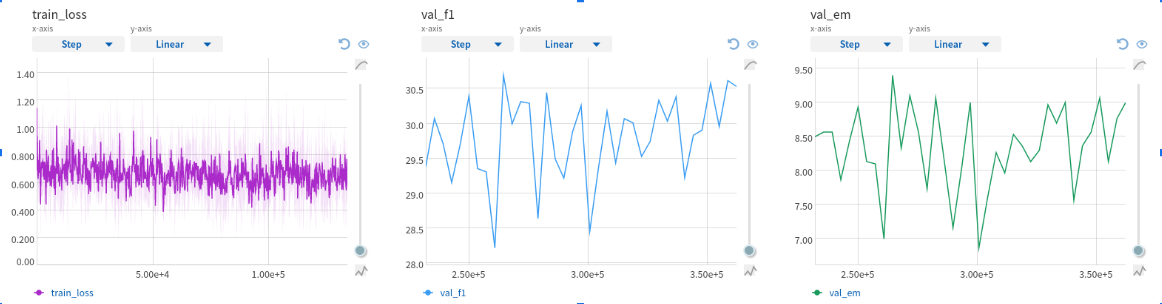



Contudo, se analisamos as predições, o modelo acabou "viciando" num determinado nome de companhia:

```
Actual: MR D.I.Y. (JOHOR) SDN BHD.
Predicted: GARDENIA BAKERIES (KL) SDN BHD.

Actual: GARDENIA BAKERIES (KL) SDN BHD.
Predicted: GARDENIA BAKERIES (KL) SDN BHD.

Actual: GUARDIAN HEALTH AND BEAUTY SDN BHD.
Predicted: GARDENIA BAKERIES (KL) SDN BHD.
```

No início do ajuste, o modelo tentou reproduzir o que havia aprendido no pré-treino:

```
Actual: GERBANG ALAF RESTAURANTS SDN BHD. Predicted: <extra_id_0><unk>.
Actual: HERO DISTRIBUTION SDN BHD. Predicted: <extra_id_0><unk>.
Actual: GARDENIA BAKERIES (KL) SDN BHD. Predicted: <extra_id_0><unk>.
Actual: TEO HENG STATIONERY & BOOKS. Predicted: <extra_id_0><unk>.
Actual: 99 SPEED MART S/B. Predicted: <extra_id_0><unk>.
```

Mas logo encontrou alguma associação entre a entrada e a empresa `GARDENIA BAKERIES (KL) SDN BHD`.

Pretendo testar outra abordagem de pré-treino do paper, que, apresentando os patches e o texto, pede ao modelo indicar se os patches contém o texto apresentado.